In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import time

import pandas_profiling
from pandas_profiling import ProfileReport

import scipy
from scipy.stats import multivariate_normal
import scipy.linalg
from sklearn.model_selection import train_test_split

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

##**Part 1**
The first part of this project is to read and process the data. Fortunately for me, most of the preprocessing has been done. According to Kaggle, the downloadable dataset is the outcome of PCA on some larger dataset. This results in not knowing the names of the columns. Oddly enough there are no N/A values but when preform dropna 70% of the data is dropped. I believe this is due to the precision, my conclusion is that dropna has a desired precision and if the precision of the data is larger than the "desired precision" then the data point is considered    N/A. I decided not to normalize the data initially because there was no true reason off the bat, but at another part I will see what normalizing the data does to the accuracy of the model. I deceided to plot the data just to get an idea of what the features looked like.

In [ ]:
# Reads the dataset
data = pd.read_csv('creditcard.csv')

# Creates a test set used when evening the data
test_class = data['Class'].to_numpy()
test = data.drop(columns = 'Class').to_numpy()

# Creates a list of headers for LASSO feature selection
headers = []
for col in data:
  headers.append(col)

# Plots the each column of data
for col in data.columns:
    data[col].plot(figsize=(8, 8))
    plt.title(col + " VS Datapoint")
    plt.ylabel(col)
    plt.xlabel("Datapoint")
    plt.show()

# Plots histograms of each column of data
for col in data.columns:
  plt.hist(data[col], bins=15)
  plt.title(col + " Histogram")
  plt.ylabel("Frequency")
  plt.xlabel("Bin Size")
  plt.show()

# Initializes the Predictors and Response
Y = data['Class'].to_numpy()
X = data.drop(columns = 'Class').to_numpy()

datapoints = X.shape[0]
features = X.shape[1]

# Splits the predictors and response into testing and training sets
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.2, random_state=1)

This block of code is used to even out the number of fraudulent cases vs non fraudulent cases so that we can use a seperate method to determine the affects on accuracy. It can also be used to weight the size of each class

In [ ]:
# Desired number of datapoints in the class of zeros
num_zeros = 11500
count = 0

# Initially creates a dataframe of all the fraud cases
test = data.iloc[np.where(test_class == 1)]

# Loops through each datapoint and appends the non fraud cases to the new dataframe
for index, i in data.iterrows():
  if i['Class'] == 0 and count <= num_zeros:
    new_def = pd.DataFrame(i)
    new_def = new_def.transpose()
    frames = [test, new_def]
    test = pd.concat(frames)
    count+=1

# Initializes the second set of Predictors and Response
Y1 = test['Class'].to_numpy()
X1 = test.drop(columns = 'Class').to_numpy()


# Splits the predictors and response into testing and training sets
(trainX1, testX1, trainY1, testY1) = train_test_split(X1, Y1, test_size=0.2, random_state=1)

In [ ]:
# Class used for Bayes classifaction
class BayesClassifier:
    def fit(self, X, Y):     
        # find the unique labels
        uniqueY = np.unique(Y)
        
        # find the dimensions
        n = X.shape[0]
        self.d = X.shape[1]
        self.k = uniqueY.shape[0]
        
        # initialize the outputs
        self.prior = np.zeros([self.k, 1])
        self.mu = np.zeros([self.k, self.d])
        self.Sigma = np.zeros([self.k, self.d, self.d])
        
        # compute class prior probabilities, sample means, and sample covariances
        for i, y in enumerate(uniqueY):
            # split the X into its classes
            Xi = X[Y == y]
            
            # compute the size of each class
            ni = Xi.shape[0]
            
            # compute the priors
            self.prior[i] = ni / n
            
            # compute the sample mean
            self.mu[i] = np.mean(Xi, axis = 0)
            
            # compute the centered data
            XiBar = Xi - self.mu[i]
            
            # compute the sample covariance
            self.Sigma[i] = (1/ni) * XiBar.T @ XiBar
            
    def predict(self, X):
        n = X.shape[0]
        
        posteriorPre = np.zeros([n, self.k])
        
        # compute the pdf term of the posterior probabilities
        count = 0
        for i in X:
            for j in range(self.k):
              posteriorPre[count][j] = scipy.stats.multivariate_normal.pdf(i[1], self.mu[j], self.Sigma[j], allow_singular = True)
            count +=1
                
        # compute a vector proportional to the posterior probabilities
        posterior = posteriorPre * self.prior.T

        # find the label for each datapoint by choosing the most probable class
        predictions = np.argmax(posterior, axis = 1)
        
        return predictions

##**Part 2**
Next I decided to use LASSO regression to rank the feature imoportance which will be used to reduce dimensions of the data so that we can reduce computational costs while retaining the majority of the accuracy. In previous testing this method has proved to be reliable and effective at the cost of a moderate computation time. To note, I used trainX and trainY because when using the entirety of the X and Y dataset the fitting function did not approve of extremely small values as it classified them as NaNs. The data for this model will be tested later in the project.

['Time', 'Amount', 'V3', 'V14', 'V17', 'V10', 'V4', 'V8', 'V5', 'V9', 'V16', 'V21', 'V13', 'V22', 'V23', 'V1', 'V20', 'V27', 'V15', 'V6', 'V28', 'V19', 'V25', 'V7', 'V24', 'V11', 'V12', 'V18', 'V2', 'V26']
392.23526263237


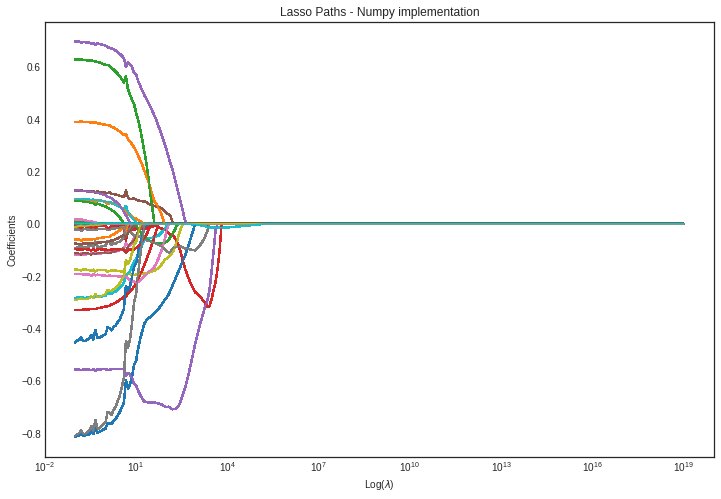

In [ ]:
%matplotlib inline
start = time.time()
plt.style.use('seaborn-white')
model = LogisticRegression(penalty="l1", solver = 'liblinear', tol= 1e-4, max_iter = int(1e6))

lamda = np.logspace(0,20,300)/10
coefs_ = []
for c in lamda:
    model.set_params(C=1/c)
    model.fit(X, Y.ravel())
    coefs_.append(model.coef_.ravel().copy())

coefs_ = np.array(coefs_)
n,_ = coefs_.shape
plt.figure(figsize = (12,8))
for i in range(n):
    plt.plot(lamda, coefs_)
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')

end = time.time()
zeros = []

# Loops through all the paths
for i in range(0, len(lamda)):

  # Loops through the values in the path
  for j in range(0,X.shape[1]):

    # When the path equals zero and is not in the list add it to the list
    if coefs_[i][j] == 0:
      if not headers[j] in zeros:
        zeros.append(headers[j])

# Reverses the list to represent a hierarchy of importance in descending order
zeros.reverse()
print(zeros)
print(end-start)

##**Models**
The used models were; Bayes, Naive Bayes, Logistic Regression, LDA, QDA, KNN, and Decision Tree. Without performing any prcoessing of the data the two best models were LDA and QDA while the worst performing models were KNN and Decision Trees. LDA and QDA performed relatively quickly compared to the other models, for example KNN took incredibly long computationaly and also performed terribly. I used three different metrics, Receiver Operating Characteristic, Area Under the Curve, and Precision and Recall Area Under the Curve. I primarily based the true evaluation off of the Precision and Recall Area Under the Curve due its capabilities to weight each class. PRAUC allows for classification of classes to be weighted based off how many fall in each class, this becomes an increasingly useful indicator for heavily imbalanced classes.


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00    227440
           1       0.16      0.65      0.26       405

    accuracy                           0.99    227845
   macro avg       0.58      0.82      0.63    227845
weighted avg       1.00      0.99      1.00    227845


Confusion Matrix:



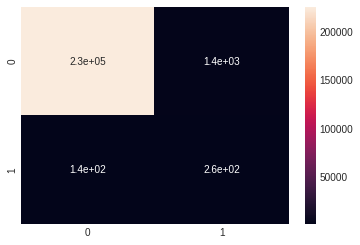

Training ROC AUC:  0.8204494035599676
Training Score:  0.9933682986240646
Training PR AUC:  0.19408446271137883



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56875
           1       0.13      0.61      0.22        87

    accuracy                           0.99     56962
   macro avg       0.57      0.80      0.61     56962
weighted avg       1.00      0.99      1.00     56962


Confusion Matrix:



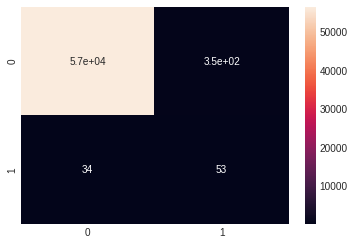

Testing ROC AUC:  0.8015295692812935
Testing Score:  0.9932762192338752
Training PR AUC:  0.14646111298826067
Finished in 0.28355932235717773 seconds


In [ ]:
# Initializes the Naive Bayes classification model
model = GaussianNB()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Print quality metrics for training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Print quality metrics for testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
# Oops, accidentally left the word training when truly it is the testing PR AUC.
# I did not want to rerun all the code so i left it as is.
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.86      0.65      0.74       405

    accuracy                           1.00    227845
   macro avg       0.93      0.83      0.87    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



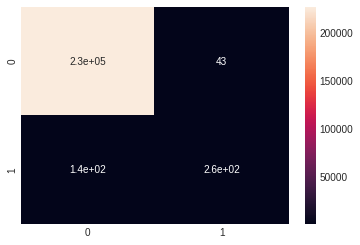

Training ROC AUC:  0.8258313955003193
Training Score:  0.9991924334525665
Training PR AUC:  0.6920557717032837



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.80      0.59      0.68        87

    accuracy                           1.00     56962
   macro avg       0.90      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



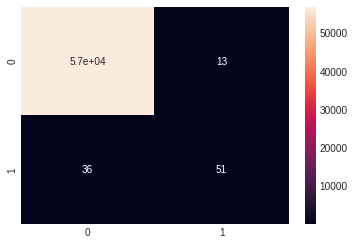

Testing ROC AUC:  0.7929891625615764
Testing Score:  0.9991397773954567
Training PR AUC:  0.562660793826232
Finished in 11.961782455444336 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.98      0.12      0.22       405

    accuracy                           1.00    227845
   macro avg       0.99      0.56      0.61    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



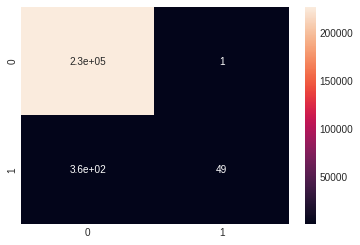

Training ROC AUC:  0.5604916287785029
Training Score:  0.9984331453400338
Training PR AUC:  0.559991470299954



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       1.00      0.01      0.02        87

    accuracy                           1.00     56962
   macro avg       1.00      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



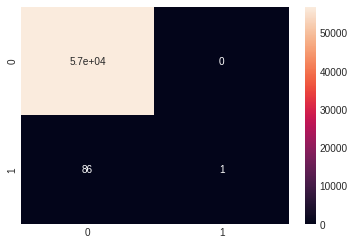

Testing ROC AUC:  0.5057471264367817
Testing Score:  0.9984902215512096
Training PR AUC:  0.0352576420389118
Finished in 1392.2782351970673 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.87      0.77      0.82       405

    accuracy                           1.00    227845
   macro avg       0.93      0.88      0.91    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



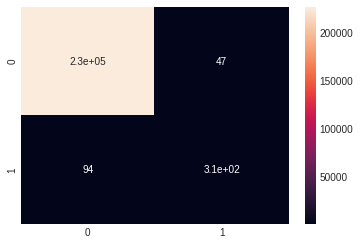

Training ROC AUC:  0.8838472933303805
Training Score:  0.9993811582435428
Training PR AUC:  0.7458116581389533



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.84      0.74      0.79        87

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



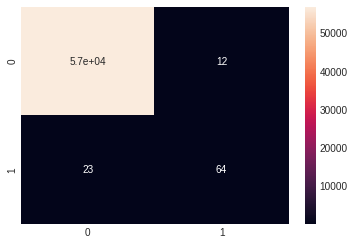

Testing ROC AUC:  0.8677105974485284
Testing Score:  0.999385555282469
Training PR AUC:  0.6534409206529557
Finished in 1.5908238887786865 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      0.98      0.99    227440
           1       0.06      0.88      0.11       405

    accuracy                           0.98    227845
   macro avg       0.53      0.93      0.55    227845
weighted avg       1.00      0.98      0.99    227845


Confusion Matrix:



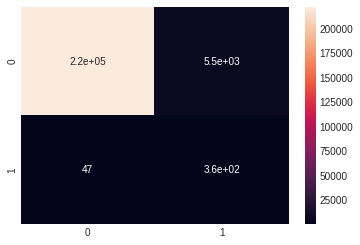

Training ROC AUC:  0.9298842076922743
Training Score:  0.9756545019640546
Training PR AUC:  0.15187261942295105



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56875
           1       0.05      0.82      0.09        87

    accuracy                           0.98     56962
   macro avg       0.52      0.90      0.54     56962
weighted avg       1.00      0.98      0.99     56962


Confusion Matrix:



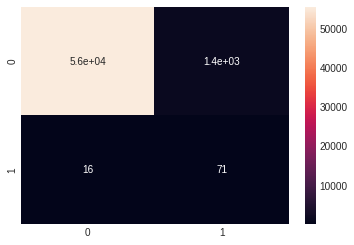

Testing ROC AUC:  0.8960020209675382
Testing Score:  0.975667989185773
Training PR AUC:  0.1129043792488951
Finished in 0.9639544486999512 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       1.00      1.00      1.00       405

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



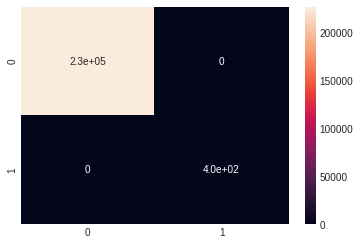

Training ROC AUC:  1.0
Training Score:  1.0
Training PR AUC:  1.0



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.82      0.71      0.76        87

    accuracy                           1.00     56962
   macro avg       0.91      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



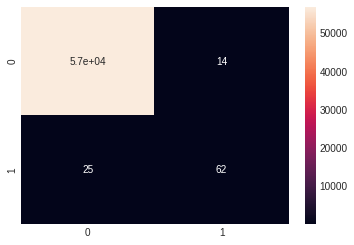

Testing ROC AUC:  0.8561987621573828
Testing Score:  0.9993153330290369
Training PR AUC:  0.5818061002152272
Finished in 24.022372484207153 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      0.79      0.88    227440
           1       0.00      0.41      0.01       405

    accuracy                           0.79    227845
   macro avg       0.50      0.60      0.44    227845
weighted avg       1.00      0.79      0.88    227845


Confusion Matrix:



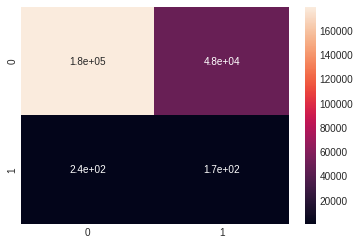

Training ROC AUC:  0.6008945243461306



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      0.79      0.88     56875
           1       0.00      0.41      0.01        87

    accuracy                           0.79     56962
   macro avg       0.50      0.60      0.44     56962
weighted avg       1.00      0.79      0.88     56962


Confusion Matrix:



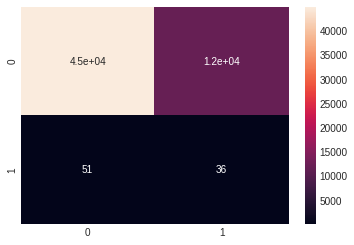

Testing ROC AUC:  0.6021229253505116
Finished in 274.2876932621002 seconds


In [ ]:
# Initializes the Bayes classification model
model = BayesClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# print quality metrics for training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
print('Training ROC AUC: ', roctrain)
print('\n')

# Print quality metrics for testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
print('Testing ROC AUC: ', roctest)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**Evened Data**
This part uses the evened data and wow, these results are amazing. By evening the data into a 1:0 492:11500 I am able to use almost every model and get incredible results. After moving past this point and comparing other combinations of models and methods this was by far the best result. Very low computation time and extremely accurate results even when weighted. I will note that I did not perfectly even the data because the results were not as good, I started with 492:492 then moved to 492:10000 and then finished with 492:11500. The top 3 models using this method are Logistic Regression, Decision Tree, and LDA and the worst performing model was Bayes Classifier. This method increased the accuracy and decreased the computation time for all models. For Logistic Regerssion the original method had 69% training accuracy and 56% testing accuracy, comparing this to the evening method we got 99.4% training accuracy and 99.6% testing accuracy. This method is the most succesful method out of all the methods tried.


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      9213
         1.0       0.59      0.99      0.74       381

    accuracy                           0.97      9594
   macro avg       0.79      0.98      0.86      9594
weighted avg       0.98      0.97      0.98      9594


Confusion Matrix:



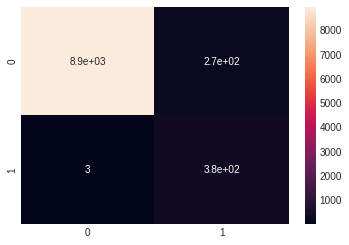

Training ROC AUC:  0.981572598117518
Training Score:  0.9718574108818011
Training PR AUC:  0.826956809676899



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2288
         1.0       0.66      1.00      0.80       111

    accuracy                           0.98      2399
   macro avg       0.83      0.99      0.89      2399
weighted avg       0.98      0.98      0.98      2399


Confusion Matrix:



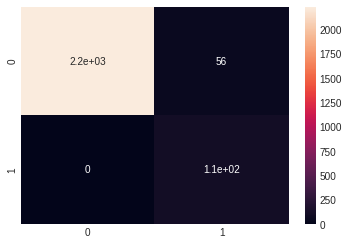

Testing ROC AUC:  0.9877622377622377
Testing Score:  0.9766569403918299
Training PR AUC:  0.8809523809523809
Finished in 0.029773950576782227 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9213
         1.0       0.99      0.87      0.92       381

    accuracy                           0.99      9594
   macro avg       0.99      0.93      0.96      9594
weighted avg       0.99      0.99      0.99      9594


Confusion Matrix:



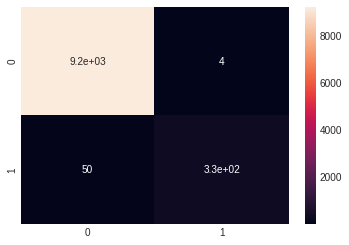

Training ROC AUC:  0.9341661175453037
Training Score:  0.9943714821763602
Training PR AUC:  0.9818129215424649



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2288
         1.0       0.99      0.89      0.94       111

    accuracy                           0.99      2399
   macro avg       0.99      0.95      0.97      2399
weighted avg       0.99      0.99      0.99      2399


Confusion Matrix:



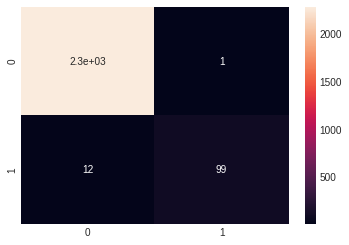

Testing ROC AUC:  0.9457274144774146
Testing Score:  0.9945810754481034
Training PR AUC:  0.9880093383481827
Finished in 0.07021522521972656 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       1.00      0.90      0.95       381

    accuracy                           1.00      9594
   macro avg       1.00      0.95      0.97      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



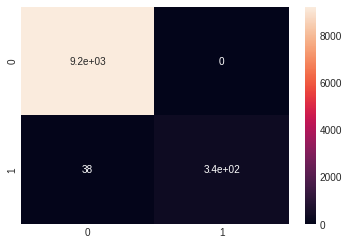

Training ROC AUC:  0.9501312335958005
Training Score:  0.9960391911611424
Training PR AUC:  0.9894780070609225



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2288
         1.0       1.00      0.93      0.96       111

    accuracy                           1.00      2399
   macro avg       1.00      0.96      0.98      2399
weighted avg       1.00      1.00      1.00      2399


Confusion Matrix:



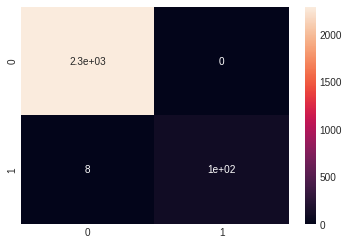

Testing ROC AUC:  0.9639639639639639
Testing Score:  0.9966652771988328
Training PR AUC:  0.946064440209728
Finished in 3.0925097465515137 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       0.99      0.96      0.98       381

    accuracy                           1.00      9594
   macro avg       0.99      0.98      0.99      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



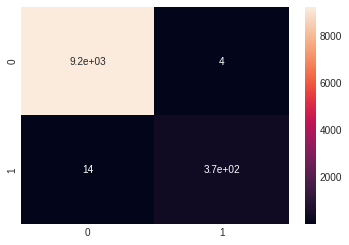

Training ROC AUC:  0.9814102120334924
Training Score:  0.99812382739212
Training PR AUC:  0.9957359530168214



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2288
         1.0       0.97      0.97      0.97       111

    accuracy                           1.00      2399
   macro avg       0.99      0.99      0.99      2399
weighted avg       1.00      1.00      1.00      2399


Confusion Matrix:



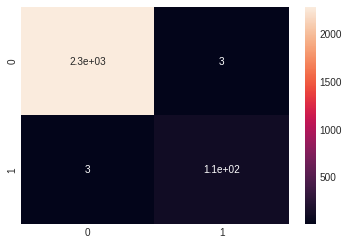

Testing ROC AUC:  0.985830892080892
Testing Score:  0.9974989578991247
Training PR AUC:  0.9976546881934633
Finished in 4.378776550292969 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       1.00      1.00      1.00       381

    accuracy                           1.00      9594
   macro avg       1.00      1.00      1.00      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



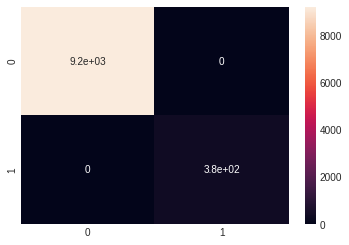

Training ROC AUC:  1.0
Training Score:  1.0
Training PR AUC:  1.0



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2288
         1.0       0.98      0.98      0.98       111

    accuracy                           1.00      2399
   macro avg       0.99      0.99      0.99      2399
weighted avg       1.00      1.00      1.00      2399


Confusion Matrix:



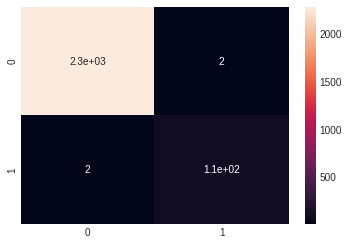

Testing ROC AUC:  0.9905539280539281
Testing Score:  0.9983326385994165
Training PR AUC:  0.9651222936375533
Finished in 0.26517200469970703 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.90      0.10      0.17      9213
         1.0       0.03      0.73      0.06       381

    accuracy                           0.12      9594
   macro avg       0.46      0.42      0.12      9594
weighted avg       0.86      0.12      0.17      9594


Confusion Matrix:



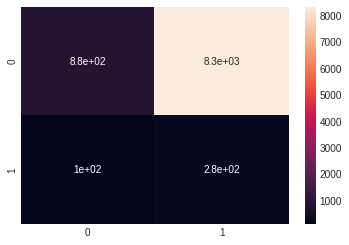

Training ROC AUC:  0.41521267021693925



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.88      0.09      0.16      2288
         1.0       0.04      0.77      0.07       111

    accuracy                           0.12      2399
   macro avg       0.46      0.43      0.12      2399
weighted avg       0.84      0.12      0.15      2399


Confusion Matrix:



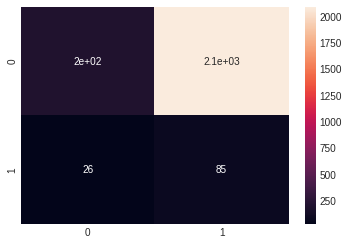

Testing ROC AUC:  0.42615211365211364
Finished in 11.532267332077026 seconds


In [ ]:
# Initializes the Bayes classification model
model = BayesClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
print('Training ROC AUC: ', roctrain)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
print('Testing ROC AUC: ', roctest)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9213
         1.0       0.72      0.95      0.82       381

    accuracy                           0.98      9594
   macro avg       0.86      0.97      0.91      9594
weighted avg       0.99      0.98      0.98      9594


Confusion Matrix:



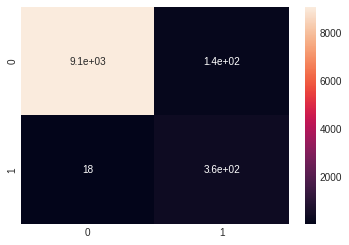

Training ROC AUC:  0.9688885356279342
Training Score:  0.983739837398374
Training PR AUC:  0.8251216091237363



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2288
         1.0       0.75      0.99      0.86       111

    accuracy                           0.98      2399
   macro avg       0.88      0.99      0.92      2399
weighted avg       0.99      0.98      0.99      2399


Confusion Matrix:



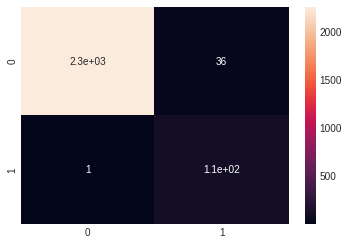

Testing ROC AUC:  0.9876283626283627
Testing Score:  0.9845769070446019
Training PR AUC:  0.8692275497344921
Finished in 0.016033649444580078 seconds


In [ ]:
# Initializes the Naive Bayes classification model
model = GaussianNB()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX1,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX1)

# Predicts for the testing set
predictedY = model.predict(testX1)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
y_score = model.predict_proba(trainX1)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
y_score = model.predict_proba(testX1)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**LASSO Reduction**
By using Lasso Regression we ranked the features and I decided that it would be interesting to see how feeding the top 5 parameters to the models to determine how it affected the models. To conclude, it appears that the "Average Accuracy" increases for some of the models but computation time is greately reduced especially for methods like KNN. The top performing models were LDA and QDA and within these models we see a slight increase in false negatives and a dramatic decrease in false negatives. To me this is not desirable because I would rather have to contact people regarding fraud where fraud did not occur than completely miss the fact that fraud occured. On the flip side the computational time was greatly decreased, for KNN's computation time decreased from roughly 24 minutes to 15 seconds.

In [ ]:
dropping = []
count = 0

# adds columns in index locations greater than the top five features
for i in zeros:
  if count >= 5:
    dropping.append(i)
  count +=1
  
data2 = data
data2 = data2.drop(columns = dropping)

Y1 = data2['Class'].to_numpy()
X1 = data2.drop(columns = 'Class').to_numpy()

(trainX, testX, trainY, testY) = train_test_split(X1, Y1, test_size=0.2, random_state=1)


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.55      0.66      0.60       405

    accuracy                           1.00    227845
   macro avg       0.77      0.83      0.80    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



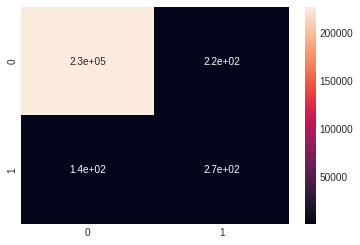

Training ROC AUC:  0.830382751874867
Training Score:  0.9984375342886611
Training PR AUC:  0.5937102967219907



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.43      0.57      0.50        87

    accuracy                           1.00     56962
   macro avg       0.72      0.79      0.75     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



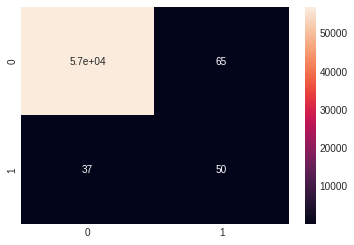

Testing ROC AUC:  0.7867848932676519
Testing Score:  0.9982093325374811
Training PR AUC:  0.4979427565439029
Finished in 0.1297008991241455 seconds


In [ ]:
# Initializes the Naive Bayes classification model
model = GaussianNB()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Print quality metrics for training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Print quality metrics for testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
# Oops, accidentally left the word training when truly it is the testing PR AUC.
# I did not want to rerun all the code so i left it as is.
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.34      0.54      0.42       405

    accuracy                           1.00    227845
   macro avg       0.67      0.77      0.71    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



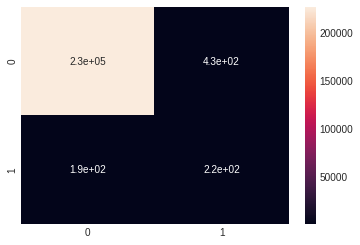

Training ROC AUC:  0.7694316612602754
Training Score:  0.9973095744914305
Training PR AUC:  0.4466648098616548



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.29      0.48      0.36        87

    accuracy                           1.00     56962
   macro avg       0.64      0.74      0.68     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



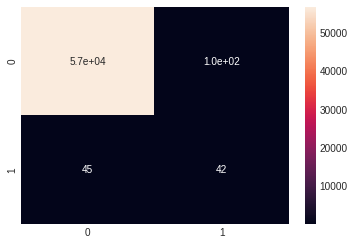

Testing ROC AUC:  0.7404562334217507
Testing Score:  0.9973666654962958
Training PR AUC:  0.38052371160526244
Finished in 1.6686687469482422 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.94      0.08      0.15       405

    accuracy                           1.00    227845
   macro avg       0.97      0.54      0.58    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



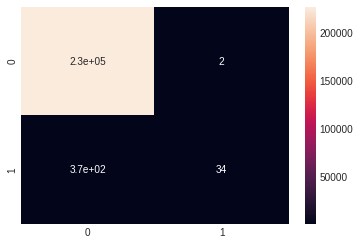

Training ROC AUC:  0.5419709118779935
Training Score:  0.9983629221619961
Training PR AUC:  0.4866540053903889



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.50      0.01      0.02        87

    accuracy                           1.00     56962
   macro avg       0.75      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



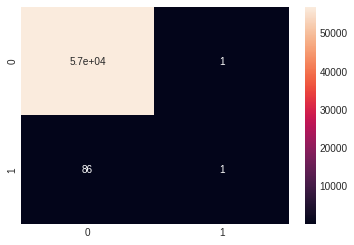

Testing ROC AUC:  0.5057383352279904
Testing Score:  0.9984726659878516
Training PR AUC:  0.02020288294336252
Finished in 9.560260772705078 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.84      0.75      0.79       405

    accuracy                           1.00    227845
   macro avg       0.92      0.87      0.90    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



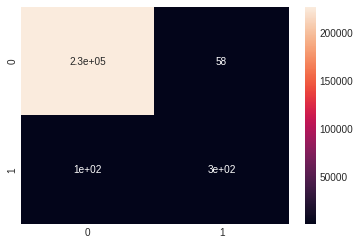

Training ROC AUC:  0.8739465679186044
Training Score:  0.999297768219623
Training PR AUC:  0.6936213857157288



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.81      0.70      0.75        87

    accuracy                           1.00     56962
   macro avg       0.91      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



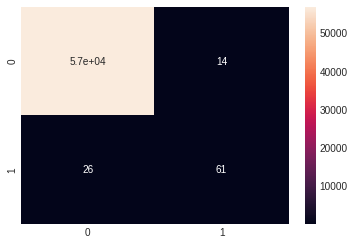

Testing ROC AUC:  0.8504516357206012
Testing Score:  0.9992977774656788
Training PR AUC:  0.6154638169206055
Finished in 0.2022416591644287 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00    227440
           1       0.14      0.86      0.24       405

    accuracy                           0.99    227845
   macro avg       0.57      0.92      0.62    227845
weighted avg       1.00      0.99      0.99    227845


Confusion Matrix:



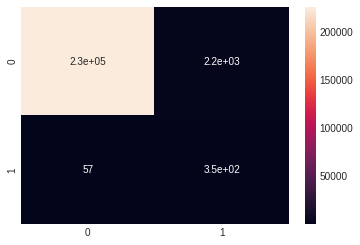

Training ROC AUC:  0.9248613390914657
Training Score:  0.9902302003555048
Training PR AUC:  0.5403184874526686



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56875
           1       0.12      0.79      0.21        87

    accuracy                           0.99     56962
   macro avg       0.56      0.89      0.60     56962
weighted avg       1.00      0.99      0.99     56962


Confusion Matrix:



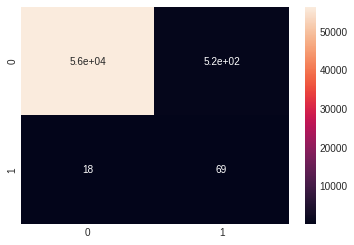

Testing ROC AUC:  0.8920242516104585
Testing Score:  0.990642884730171
Training PR AUC:  0.4465170563823286
Finished in 0.1503744125366211 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       1.00      1.00      1.00       405

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



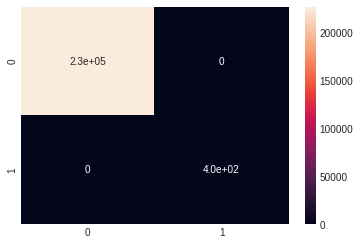

Training ROC AUC:  1.0
Training Score:  1.0
Training PR AUC:  1.0



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.73      0.71      0.72        87

    accuracy                           1.00     56962
   macro avg       0.86      0.86      0.86     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



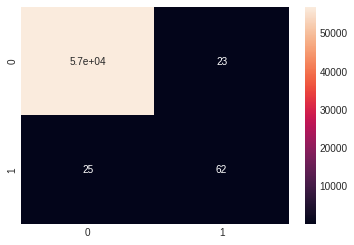

Testing ROC AUC:  0.8561196412782619
Testing Score:  0.9991573329588147
Training PR AUC:  0.5202495719777979
Finished in 2.563904047012329 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX,trainY)
y_score = model.predict_proba(trainX)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX,testY)
y_score = model.predict_proba(testX)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00    227440
           1       0.16      0.53      0.25       405

    accuracy                           0.99    227845
   macro avg       0.58      0.76      0.62    227845
weighted avg       1.00      0.99      1.00    227845


Confusion Matrix:



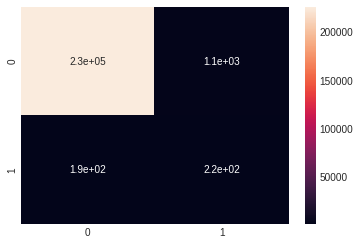

Training ROC AUC:  0.7641561144331105



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.13      0.45      0.20        87

    accuracy                           0.99     56962
   macro avg       0.56      0.72      0.60     56962
weighted avg       1.00      0.99      1.00     56962


Confusion Matrix:



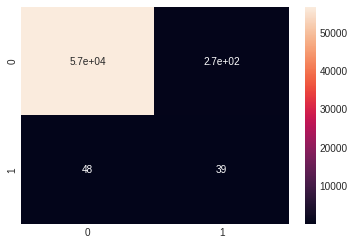

Testing ROC AUC:  0.7217555134520652
Finished in 78.65901374816895 seconds


In [ ]:
# Initializes the Bayes classification model
model = BayesClassifier()

# Records the start time
start = time.time()

# Fits the model to the data
model.fit(trainX,trainY)

# Predicts for the training set
trainpredictions = model.predict(trainX)

# Predicts for the testing set
predictedY = model.predict(testX)

# Records the stopping time
end = time.time()

# print quality metrics for training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
print('Training ROC AUC: ', roctrain)
print('\n')

# Print quality metrics for testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
print('Testing ROC AUC: ', roctest)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**PCA**
I decided to try PCA even though it realistically should not be applied twice. I kept it to show why performing PCA twice should be advised against. The result is that even though the "majority of information" is retained the classifiers can not correctly classify fraud becuase all of the information is so convoluted making it hard to notice the difference . But using PCA and then another DR method may be appropriate.


In [ ]:
# Reinitializes the testing and training sets
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
def PCA(Xtrain, alpha):        
    # find the original dimension and print it
    dimension = Xtrain.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    Xtrain -= np.mean(Xtrain, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/Xtrain.shape[0]) * Xtrain.T @ Xtrain

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = Xtrain @ basis
    
    # return points
    return A

In [ ]:
import time
start = time.time()

# Apply PCA to the data matrices and retained .99998 % of the variation so that 2 variables we left
trainX_PCA = PCA(trainX, 0.99998)
testX_PCA = PCA(testX,0.99998)


end = time.time()

print('PCA finished in', end - start, 'seconds')

The original dimension of the data is 30
The new dimension of the data is 2 and it explains 0.9999999874371645 of the variance
The original dimension of the data is 30
The new dimension of the data is 2 and it explains 0.9999999877370227 of the variance
PCA finished in 0.13763093948364258 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.00      0.00      0.00       405

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



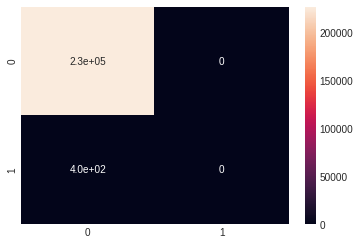

Training ROC AUC:  0.5
Training Score:  0.9982224758059207
Training PR AUC:  0.0025324579227733487



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


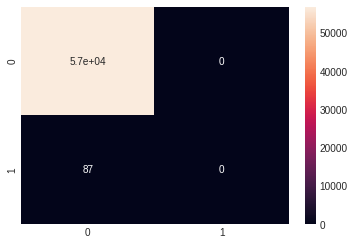

Testing ROC AUC:  0.5
Testing Score:  0.9984726659878516
Training PR AUC:  0.002082009839746982
Finished in 0.10273957252502441 seconds


In [ ]:
# Initializes the Naive Bayes classification model
model = GaussianNB()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.00      0.00      0.00       405

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



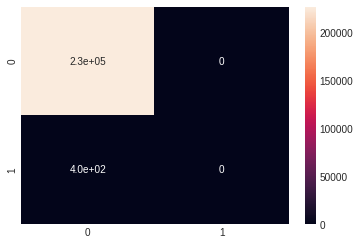

Training ROC AUC:  0.5
Training Score:  0.9982224758059207
Training PR AUC:  0.002571722799224788



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


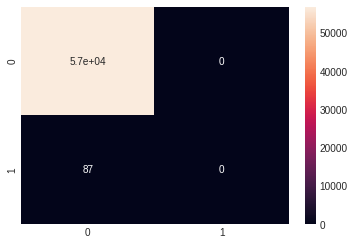

Testing ROC AUC:  0.5
Testing Score:  0.9984726659878516
Training PR AUC:  0.0023944320769939322
Finished in 1.5201139450073242 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.74      0.05      0.09       405

    accuracy                           1.00    227845
   macro avg       0.87      0.52      0.55    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



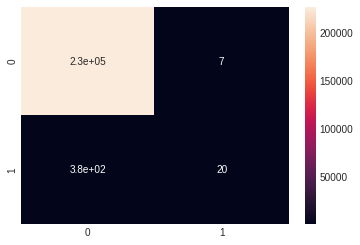

Training ROC AUC:  0.5246759693507553
Training Score:  0.9982795321380763
Training PR AUC:  0.26718130409755386



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



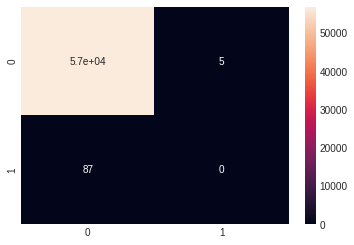

Testing ROC AUC:  0.499956043956044
Testing Score:  0.9983848881710614
Training PR AUC:  0.001856044613330245
Finished in 8.426726818084717 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.00      0.00      0.00       405

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



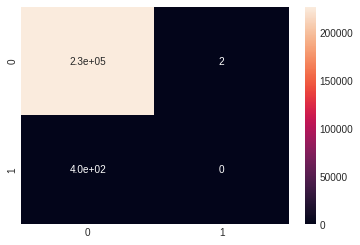

Training ROC AUC:  0.49999560323601827
Training Score:  0.998213697908666
Training PR AUC:  0.0025374036041521677



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



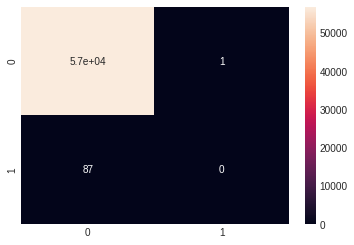

Testing ROC AUC:  0.4999912087912088
Testing Score:  0.9984551104244935
Training PR AUC:  0.0026269312964864945
Finished in 0.10512804985046387 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.00      0.00      0.00       405

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



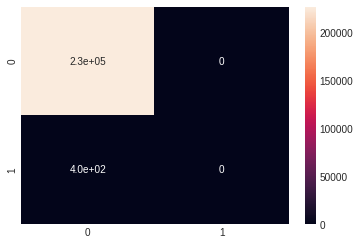

Training ROC AUC:  0.5
Training Score:  0.9982224758059207
Training PR AUC:  0.0025209943080310286



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


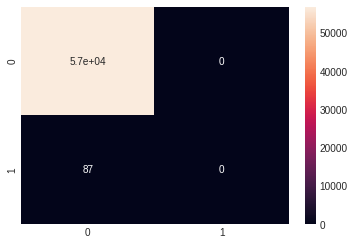

Testing ROC AUC:  0.5
Testing Score:  0.9984726659878516
Training PR AUC:  0.002080835470130818
Finished in 0.1003866195678711 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       1.00      1.00      1.00       405

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



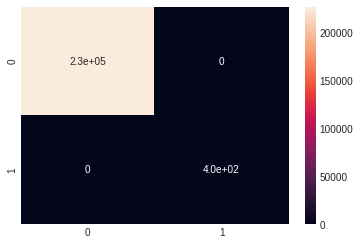

Training ROC AUC:  1.0
Training Score:  1.0
Training PR AUC:  1.0



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      0.93      0.96     56875
           1       0.01      0.23      0.01        87

    accuracy                           0.93     56962
   macro avg       0.50      0.58      0.49     56962
weighted avg       1.00      0.93      0.96     56962


Confusion Matrix:



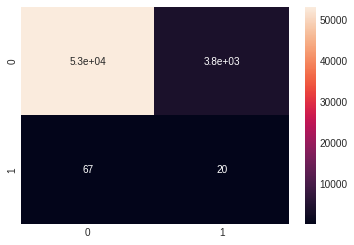

Testing ROC AUC:  0.5811315397246432
Testing Score:  0.9313050805800358
Training PR AUC:  0.002365488432888892
Finished in 1.2598302364349365 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
score_train = model.score(trainX_PCA,trainY)
y_score = model.predict_proba(trainX_PCA)[:,1]
average_precision = average_precision_score(trainY, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
score_test = model.score(testX_PCA,testY)
y_score = model.predict_proba(testX_PCA)[:,1]
average_precision = average_precision_score(testY, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Training:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.00      0.00      0.00       405

    accuracy                           1.00    227845
   macro avg       0.50      0.50      0.50    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix:



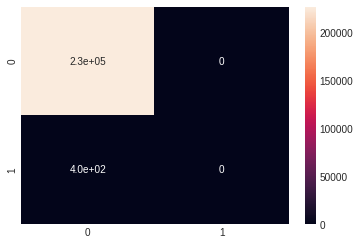

Training ROC AUC:  0.5



Classification Report for Testing:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.00      0.00      0.00        87

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


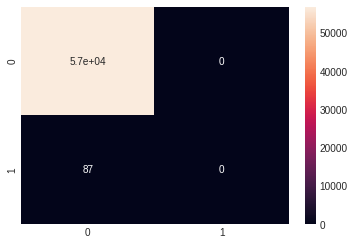

Testing ROC AUC:  0.5
Finished in 62.47589063644409 seconds


In [ ]:
# Initializes the Bayes classification model
model = BayesClassifier()

# Records the start time
start = time.time()

# Fits the trianing data
model.fit(trainX_PCA,trainY)

# Predicts with the training data
trainpredictions = model.predict(trainX_PCA)

# Predicts the testing data
predictedY = model.predict(testX_PCA)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY,trainpredictions)
print('Training ROC AUC: ', roctrain)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY,predictedY)
print('Testing ROC AUC: ', roctest)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**Part 4**
I was reading from one of Dr. Benjamin Moster assigments, https://www.usm.lmu.de/people/moster/Teaching/AI2020/exercise05_solution.pdf , and found that it can be useful to combine two dimension reduction methods. One method to quickly (PCA) reduce useless dimensions and one method (Embeddor) to unfold the remaining data into a lower dimension. I decided to test this out and compare lasso feature selection method with 3 other methods, those being; PCA and Locally Linear Embedding, PCA and Isomap Embedding, and PCA and Multi Dimensional Scaling. This section focuses on using two dimension reductions methods (one being a fast dimension reducer(PCA), the other being a slow information splitter (LLE, Isomap, MDS)). According to Dr. Benjamin Moster, there can be some benefits to this regarding overall computation time while retaining the differences in classes.

##**Locally Linear Embedding**
Using PCA with a Locally Linear Embedding model we see that the accuracy does not improve compared to LASSO but the computational time does decrese. All of the models performed terribly compared to the other methods and realistically the computational time was not significantly decreased. I would advise against using PCA and Locally Linear Embedding with this dataset.

In [ ]:
# Records the start time
start = time.time()

# Initializes the LLE class
embedding = LocallyLinearEmbedding(n_components=9, eigen_solver = 'dense')

# Applies LLE to the training set
trainX_LLE = embedding.fit_transform(trainX1)

# Applies LLE to the testing set
testX_LLE = embedding.fit_transform(testX1)

# Records the end time
end = time.time()

# Prints the runtime
print("Time in seconds: ", (end-start))

Time in seconds:  121.63425540924072



Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      9213
         1.0       0.19      0.16      0.17       381

    accuracy                           0.94      9594
   macro avg       0.58      0.57      0.57      9594
weighted avg       0.93      0.94      0.94      9594


Confusion Matrix:



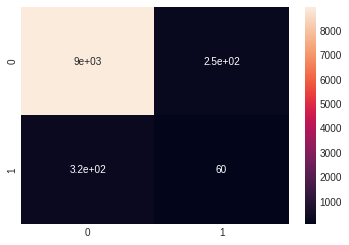

Training ROC AUC:  0.565172372828193
Training Score:  0.9404836356055868
Training PR AUC:  0.22360693845257165



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.98      0.71      0.82      2288
         1.0       0.10      0.66      0.17       111

    accuracy                           0.71      2399
   macro avg       0.54      0.68      0.50      2399
weighted avg       0.94      0.71      0.79      2399


Confusion Matrix:



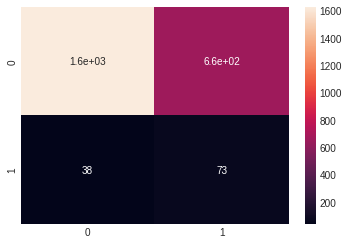

Testing ROC AUC:  0.6843795281295281
Testing Score:  0.70862859524802
Training PR AUC:  0.2383215952049699
Finished in 0.013943672180175781 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_LLE,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_LLE)

# Predicts for the testing set
predictedY = model.predict(testX_LLE)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_LLE,trainY1)
y_score = model.predict_proba(trainX_LLE)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_LLE,testY1)
y_score = model.predict_proba(testX_LLE)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      9213
         1.0       0.34      0.11      0.16       381

    accuracy                           0.96      9594
   macro avg       0.65      0.55      0.57      9594
weighted avg       0.94      0.96      0.95      9594


Confusion Matrix:



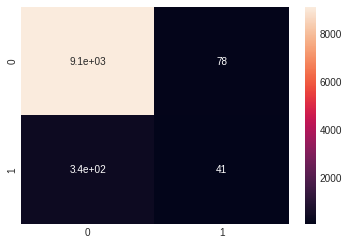

Training ROC AUC:  0.5495726254667531
Training Score:  0.9564311027725662
Training PR AUC:  0.21779142369740057



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      2288
         1.0       0.24      0.55      0.33       111

    accuracy                           0.90      2399
   macro avg       0.61      0.73      0.64      2399
weighted avg       0.94      0.90      0.92      2399


Confusion Matrix:



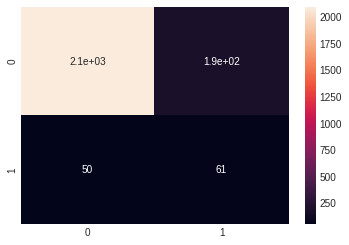

Testing ROC AUC:  0.7325982013482014
Testing Score:  0.8987077949145478
Training PR AUC:  0.3948247250272387
Finished in 0.018584012985229492 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_LLE,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_LLE)

# Predicts for the testing set
predictedY = model.predict(testX_LLE)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_LLE,trainY1)
y_score = model.predict_proba(trainX_LLE)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_LLE,testY1)
y_score = model.predict_proba(testX_LLE)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      9213
         1.0       0.00      0.00      0.00       381

    accuracy                           0.96      9594
   macro avg       0.48      0.50      0.49      9594
weighted avg       0.92      0.96      0.94      9594


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


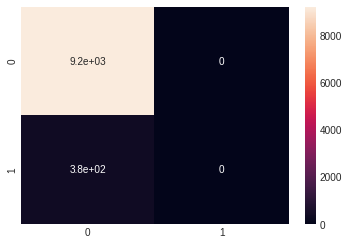

Training ROC AUC:  0.5
Training Score:  0.960287679799875
Training PR AUC:  0.21676802623809371



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      2288
         1.0       0.00      0.00      0.00       111

    accuracy                           0.95      2399
   macro avg       0.48      0.50      0.49      2399
weighted avg       0.91      0.95      0.93      2399


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


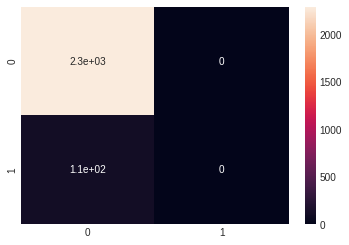

Testing ROC AUC:  0.5
Testing Score:  0.9537307211338057
Training PR AUC:  0.3945533155480685
Finished in 0.026149749755859375 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_LLE,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_LLE)

# Predicts for the testing set
predictedY = model.predict(testX_LLE)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_LLE,trainY1)
y_score = model.predict_proba(trainX_LLE)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_LLE,testY1)
y_score = model.predict_proba(testX_LLE)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       0.99      0.90      0.94       381

    accuracy                           1.00      9594
   macro avg       0.99      0.95      0.97      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



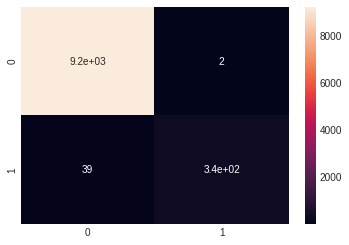

Training ROC AUC:  0.9487103553605782
Training Score:  0.9957264957264957
Training PR AUC:  0.9762457434655308



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2288
         1.0       0.30      0.27      0.28       111

    accuracy                           0.94      2399
   macro avg       0.63      0.62      0.63      2399
weighted avg       0.93      0.94      0.94      2399


Confusion Matrix:



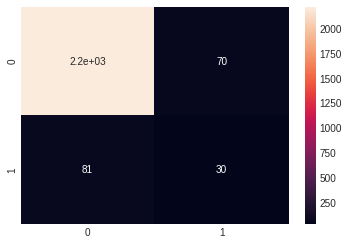

Testing ROC AUC:  0.6198379323379323
Testing Score:  0.93705710712797
Training PR AUC:  0.14566812539926338
Finished in 0.5323524475097656 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_LLE,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_LLE)

# Predicts for the testing set
predictedY = model.predict(testX_LLE)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_LLE,trainY1)
y_score = model.predict_proba(trainX_LLE)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_LLE,testY1)
y_score = model.predict_proba(testX_LLE)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       1.00      0.94      0.97       381

    accuracy                           1.00      9594
   macro avg       1.00      0.97      0.99      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



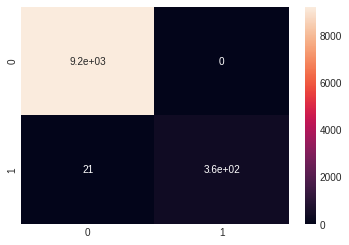

Training ROC AUC:  0.9724409448818898
Training Score:  0.9978111319574734
Training PR AUC:  0.9810296735538708



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.95      0.80      0.87      2288
         1.0       0.03      0.14      0.05       111

    accuracy                           0.77      2399
   macro avg       0.49      0.47      0.46      2399
weighted avg       0.91      0.77      0.83      2399


Confusion Matrix:



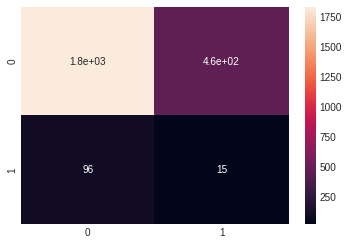

Testing ROC AUC:  0.4676986864486864
Testing Score:  0.7694872863693205
Training PR AUC:  0.04431122240008004
Finished in 0.1089482307434082 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_LLE,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_LLE)

# Predicts for the testing set
predictedY = model.predict(testX_LLE)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_LLE,trainY1)
y_score = model.predict_proba(trainX_LLE)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_LLE,testY1)
y_score = model.predict_proba(testX_LLE)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**Isomap Embedding**
Using PCA and Isomap Embedding we can see that the computational time is worse than LASSO and for the most part the testing results are decent while the training results are poor which is quite odd. LDA and Logistic Regression did well on both the training and testing while every other model did not perform at the same level. Overall, this method is relatively ineffective and computationally expensive for this dataset.

In [ ]:
# Records the start time
start = time.time()

# Initializes the Isomap class
embedding = Isomap(n_components=10, eigen_solver = 'dense')

# Applies Isomap to the training set
trainX_ISO = embedding.fit_transform(trainX1)

# Applies Isomap to the testing set
testX_ISO = embedding.fit_transform(testX1)

# Records the end time
end = time.time()

# Prints the runtime
print('Time in seconds: ', (end-start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/

Time in seconds:  204.11988854408264



Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9213
         1.0       0.84      0.89      0.86       381

    accuracy                           0.99      9594
   macro avg       0.92      0.94      0.93      9594
weighted avg       0.99      0.99      0.99      9594


Confusion Matrix:



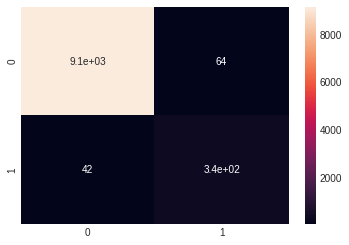

Training ROC AUC:  0.9414085368928363
Training Score:  0.9889514279758183
Training PR AUC:  0.8775850507135544



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2288
         1.0       0.05      1.00      0.09       111

    accuracy                           0.05      2399
   macro avg       0.02      0.50      0.04      2399
weighted avg       0.00      0.05      0.00      2399


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


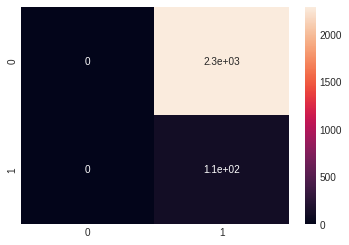

Testing ROC AUC:  0.5
Testing Score:  0.046269278866194245
Training PR AUC:  0.046269278866194245
Finished in 0.02081012725830078 seconds


In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_ISO,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_ISO)

# Predicts for the testing set
predictedY = model.predict(testX_ISO)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_ISO,trainY1)
y_score = model.predict_proba(trainX_ISO)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_ISO,testY1)
y_score = model.predict_proba(testX_ISO)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9213
         1.0       1.00      0.81      0.89       381

    accuracy                           0.99      9594
   macro avg       1.00      0.90      0.95      9594
weighted avg       0.99      0.99      0.99      9594


Confusion Matrix:



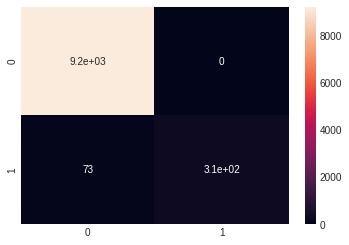

Training ROC AUC:  0.9041994750656168
Training Score:  0.9923910777569314
Training PR AUC:  0.9065241659637316



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2288
         1.0       1.00      0.83      0.91       111

    accuracy                           0.99      2399
   macro avg       1.00      0.91      0.95      2399
weighted avg       0.99      0.99      0.99      2399


Confusion Matrix:



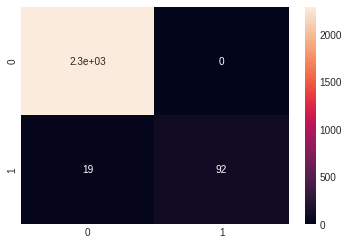

Testing ROC AUC:  0.9144144144144144
Testing Score:  0.992080033347228
Training PR AUC:  0.9351909723316905
Finished in 0.029550790786743164 seconds


In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_ISO,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_ISO)

# Predicts for the testing set
predictedY = model.predict(testX_ISO)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_ISO,trainY1)
y_score = model.predict_proba(trainX_ISO)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_ISO,testY1)
y_score = model.predict_proba(testX_ISO)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9213
         1.0       1.00      0.88      0.93       381

    accuracy                           1.00      9594
   macro avg       1.00      0.94      0.97      9594
weighted avg       1.00      1.00      0.99      9594


Confusion Matrix:



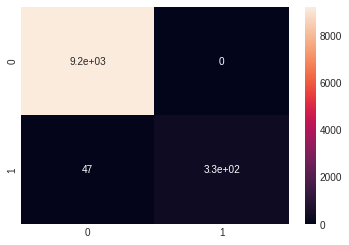

Training ROC AUC:  0.9383202099737533
Training Score:  0.9951011048572024
Training PR AUC:  0.9126128615589331



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      2288
         1.0       0.24      0.66      0.35       111

    accuracy                           0.89      2399
   macro avg       0.61      0.78      0.65      2399
weighted avg       0.95      0.89      0.91      2399


Confusion Matrix:



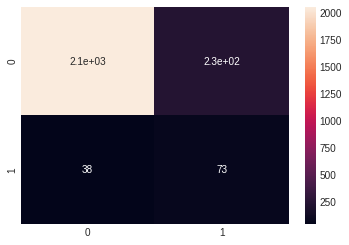

Testing ROC AUC:  0.778566591066591
Testing Score:  0.8882867861609004
Training PR AUC:  0.5461556001796055
Finished in 1.6739847660064697 seconds


In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_ISO,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_ISO)

# Predicts for the testing set
predictedY = model.predict(testX_ISO)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_ISO,trainY1)
y_score = model.predict_proba(trainX_ISO)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_ISO,testY1)
y_score = model.predict_proba(testX_ISO)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       1.00      0.90      0.94       381

    accuracy                           1.00      9594
   macro avg       1.00      0.95      0.97      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



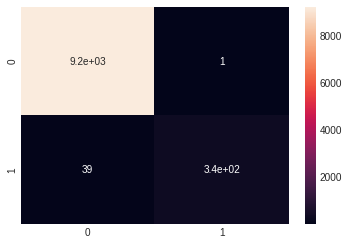

Training ROC AUC:  0.9487646264991867
Training Score:  0.9958307275380446
Training PR AUC:  0.9846470611831771



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2288
         1.0       1.00      0.92      0.96       111

    accuracy                           1.00      2399
   macro avg       1.00      0.96      0.98      2399
weighted avg       1.00      1.00      1.00      2399


Confusion Matrix:



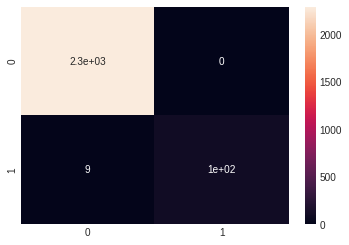

Testing ROC AUC:  0.9594594594594594
Testing Score:  0.9962484368486869
Training PR AUC:  0.9226704820702321
Finished in 0.42962074279785156 seconds


In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_ISO,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_ISO)

# Predicts for the testing set
predictedY = model.predict(testX_ISO)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_ISO,trainY1)
y_score = model.predict_proba(trainX_ISO)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_ISO,testY1)
y_score = model.predict_proba(testX_ISO)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')


Classification Report for Training:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9213
         1.0       1.00      1.00      1.00       381

    accuracy                           1.00      9594
   macro avg       1.00      1.00      1.00      9594
weighted avg       1.00      1.00      1.00      9594


Confusion Matrix:



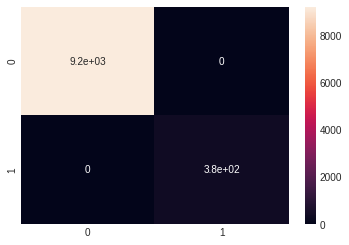

Training ROC AUC:  1.0
Training Score:  1.0
Training PR AUC:  1.0



Classification Report for Testing:

               precision    recall  f1-score   support

         0.0       0.99      0.69      0.82      2288
         1.0       0.13      0.93      0.22       111

    accuracy                           0.70      2399
   macro avg       0.56      0.81      0.52      2399
weighted avg       0.95      0.70      0.79      2399


Confusion Matrix:



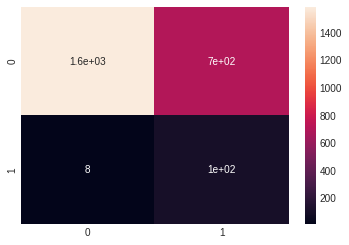

Testing ROC AUC:  0.810554873054873
Testing Score:  0.7040433513964152
Training PR AUC:  0.12206338935592066
Finished in 0.11236691474914551 seconds


In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_ISO,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_ISO)

# Predicts for the testing set
predictedY = model.predict(testX_ISO)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_ISO,trainY1)
y_score = model.predict_proba(trainX_ISO)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_ISO,testY1)
y_score = model.predict_proba(testX_ISO)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**Multidimensional Scaling**
Using PCA and Multidimensional Scaling the computational time is significantly increased regarding the fitting process. Also we can see that the training results are pretty good while the testing results are terrible. Overall I would not recommend using PCA and Multidimensional Scaling for this dataset while it does seem promising for other datasets.

In [ ]:
from sklearn.manifold import MDS

# Records the start time
start = time.time()

# Initializes the MultiDimensional Scaling class
embedding = MDS(n_components=10)

# Applies the MDS to the training set
trainX_MDS = embedding.fit_transform(trainX1)

# Applies the MDS to the testing set
testX_MDS = embedding.fit_transform(testX1)

# Records the end time
end = time.time()

# Prints the run time
print('Time in seconds: ', (end-start))

KeyboardInterrupt: ignored

In [ ]:
# Initializes the Quadratic Discriminant Analysis classification model
model = QuadraticDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_MDS,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_MDS)

# Predicts for the testing set
predictedY = model.predict(testX_MDS)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_MDS,trainY1)
y_score = model.predict_proba(trainX_MDS)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_MDS,testY1)
y_score = model.predict_proba(testX_MDS)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

In [ ]:
# Initializes the Linear Discriminant Analysis classification model
model = LinearDiscriminantAnalysis()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_MDS,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_MDS)

# Predicts for the testing set
predictedY = model.predict(testX_MDS)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_MDS,trainY1)
y_score = model.predict_proba(trainX_MDS)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_MDS,testY1)
y_score = model.predict_proba(testX_MDS)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

In [ ]:
# Initializes the Logistic Regression classification model
model = LogisticRegression(max_iter = 10000)

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_MDS,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_MDS)

# Predicts for the testing set
predictedY = model.predict(testX_MDS)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_MDS,trainY1)
y_score = model.predict_proba(trainX_MDS)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_MDS,testY1)
y_score = model.predict_proba(testX_MDS)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

In [ ]:
# Initializes the K Nearest Neighbors classification model
model = KNeighborsClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_MDS,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_MDS)

# Predicts for the testing set
predictedY = model.predict(testX_MDS)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_MDS,trainY1)
y_score = model.predict_proba(trainX_MDS)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_MDS,testY1)
y_score = model.predict_proba(testX_MDS)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

In [ ]:
# Initializes the Decision Tree classification model
model = DecisionTreeClassifier()

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX_MDS,trainY1)

# Predicts for the training set
trainpredictions = model.predict(trainX_MDS)

# Predicts for the testing set
predictedY = model.predict(testX_MDS)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX_MDS,trainY1)
y_score = model.predict_proba(trainX_MDS)[:,1]
average_precision = average_precision_score(trainY1, y_score)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('Training PR AUC: ', average_precision)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX_MDS,testY1)
y_score = model.predict_proba(testX_MDS)[:,1]
average_precision = average_precision_score(testY1, y_score)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)
print('Training PR AUC: ', average_precision)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**KMeans Clustering**
The last thing I tried was Kmeans Clustering due to its stregnth of being capable of pulling apart the means of each class to correctly classify each scenario. Overall this method does a good job at reducing false negatives but does a poor job at predicting fraud. Overall I would not recommend this model for this dataset. Also the metrics that I used in the prior models do not perform well in this model, reason uknown.

In [ ]:
from sklearn.cluster import KMeans

# Initializes the KMeans Clustering class
model = KMeans(n_clusters=2, random_state = 0)

# Records the start time
start = time.time()

# Fits the model to the training data
model.fit(trainX1)

# Predicts using training data
trainpredictions = model.predict(trainX1)

# Predicts using testing data
predictedY = model.predict(testX1)

# Records the end time
end = time.time()

# Prints the quality metrics for the training set
print('\nClassification Report for Training:\n\n', classification_report(trainY1, trainpredictions))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(trainY1, trainpredictions), annot = True)
plt.show(ax)
roctrain = roc_auc_score(trainY1,trainpredictions)
score_train = model.score(trainX1,trainY1)
print('Training ROC AUC: ', roctrain)
print('Training Score: ', score_train)
print('\n')

# Prints the quality metrics for the testing set
print('\nClassification Report for Testing:\n\n', classification_report(testY1, predictedY))
print('\nConfusion Matrix:\n')
ax = sn.heatmap(confusion_matrix(testY1, predictedY), annot = True)
plt.show(ax)
roctest = roc_auc_score(testY1,predictedY)
score_test = model.score(testX1,testY1)
print('Testing ROC AUC: ', roctest)
print('Testing Score: ', score_test)

# Prints the runtime
print('Finished in', end - start, 'seconds')

##**Conclusion**
To conclude, the best method was to process the data in such a way to even out the number fraud and non fraud cases. When I say "even out" I do not mean perfectly even, what I mean is to remove the heavy imbalance seen in the original dataset. Doing this every single model performs significantly better and also has a big decrease in computational time. Using Lasso feature selection I was able to produce some models that performed better and some models that performed worse. Lasso Feature selection allowed for a decrease in computational time across the board. The final method was using two dimensional reducers and the result was a complete failure. This data set did not cooperate well with these methods and it was more convenient to just download the data and run the models with no preprocessing. Over all I am pleased with my results, especially with the logistic regression by evening the data. I think this project was a success and comparing my results to other kaggle posts I believe that I achieved one of the highest accuracy scores of them all.